In [1]:
import random

import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

from InstaceNormalization import InstanceNormalization

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
PATH = '../'
BUFFER_SIZE=1000
BATCH_SIZE=16

In [66]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.reduce_max(image, axis=-1, keepdims=True)

    image = (image / 127.5) - 1.0
    return image

In [83]:
def shift(image):
    rangew, rangeh = 5, 20
    rndw,rndh = random.randint(-rangew,rangew),random.randint(-rangeh,rangeh) #random pixel shift
    if rndh>0:
        image = tf.pad(image, [[abs(rndh), 0], [0, 0], [0, 0]], constant_values=-1.0)
    else:
        image = tf.pad(image, [[0, abs(rndh)], [0, 0], [0, 0]], constant_values=-1.0)
    if rndw>0:
        image = tf.pad(image, [[0, 0], [abs(rndw), 0], [0, 0]], constant_values=-1.0)
    else:
        image = tf.pad(image, [[0, 0], [0, abs(rndw)], [0, 0]], constant_values=-1.0)
        
    woffset = abs(rndw) if rndw<0 else 0
    hoffset = abs(rndh) if rndh<0 else 0
    image = tf.image.crop_to_bounding_box(image, hoffset, woffset, 64,64)
    return image

In [87]:
def create_content_dataset():
    train_dataset_1 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/Roboto-Regular/*.jpg'), shuffle=False).map(load,num_parallel_calls=AUTOTUNE)
   
    train_dataset = tf.data.Dataset.zip((train_dataset_1.map(shift,num_parallel_calls=AUTOTUNE),
                                         train_dataset_1.map(shift,num_parallel_calls=AUTOTUNE),
                                         train_dataset_1.map(shift,num_parallel_calls=AUTOTUNE),
                                         train_dataset_1))
 
    train_dataset = train_dataset.shuffle(BUFFER_SIZE*4)
    
    train_size = int(0.85 * train_dataset.cardinality().numpy())
    test_dataset = train_dataset.skip(train_size)
    train_dataset = train_dataset.take(train_size)
    
    train_dataset = train_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    
    return train_dataset, test_dataset


In [88]:
train_dataset, test_dataset = create_content_dataset()

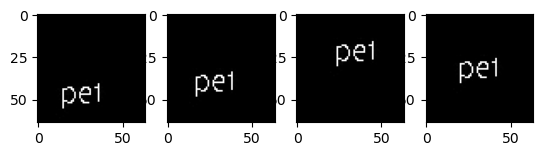

In [89]:
sample_1 = next(iter(train_dataset))
plt.subplot(241)
plt.imshow(sample_1[0][0] * 0.5 + 0.5, cmap='gray')
plt.subplot(242)
plt.imshow(sample_1[1][0] * 0.5 + 0.5, cmap='gray')
plt.subplot(243)
plt.imshow(sample_1[2][0] * 0.5 + 0.5, cmap='gray')
plt.subplot(244)
plt.imshow(sample_1[-1][0] * 0.5 + 0.5, cmap='gray')



(array([4023.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          73.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

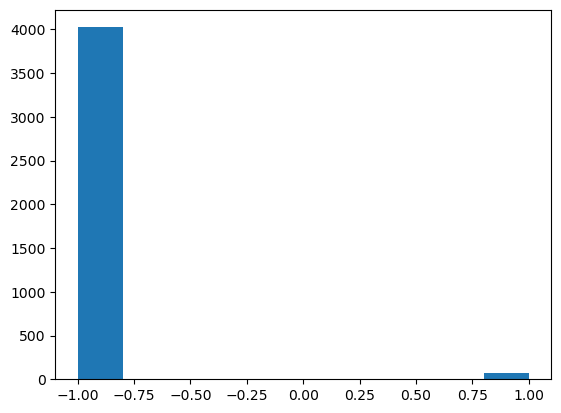

In [92]:
plt.hist(sample_1[-1][0].numpy().flatten())